# Phase 4 - Track 1: RFM-Enhanced Clustering
## Intelligent Customer Segmentation with Behavioral Overlays

**Project:** Online Retail Intelligence System  
**Dataset:** 5,878 customers from UCI Online Retail II  
**Objective:** Refine RFM segmentation with advanced behavioral features

---

### 📋 Notebook Outline
1. Data Loading & Preparation
2. Feature Selection (RFM + Behavioral)
3. Optimal k Determination
4. Model Training & Validation
5. Cluster Profiling
6. Business Insights & Recommendations

---

In [10]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
import json
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


---
## 1. Data Loading & Exploration

Load the master features dataset created in Phase 3.

In [6]:
# Load features
path = "/home/cairo/code/portfolio/customer-segmentation/data/"
path_processed = "/home/cairo/code/portfolio/customer-segmentation/data/processed/"
path_reports = "/home/cairo/code/portfolio/customer-segmentation/outputs/reports/"
path_features = "/home/cairo/code/portfolio/customer-segmentation/data/features/"
path_campaigns = "/home/cairo/code/portfolio/customer-segmentation/outputs/campaigns/"
path_figures = "/home/cairo/code/portfolio/customer-segmentation/outputs/figures/"
path_models = "/home/cairo/code/portfolio/customer-segmentation/outputs/models/"

features_df = pd.read_csv(path_features + 'features_master.csv')

print(f"Dataset Shape: {features_df.shape}")
print(f"\nCustomers: {features_df['CustomerID'].nunique():,}")
print(f"Features: {len(features_df.columns)}")

# Display first few rows
features_df.head()

Dataset Shape: (5878, 52)

Customers: 5,878
Features: 52


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_Sum,Segment,...,return_value,days_since_last,tenure_days,activity_rate,engagement_consistency,days_overdue,churn_risk_score,loyalty_index,is_at_risk,purchase_frequency
0,12346.0,326,12,77556.46,2,5,5,255,12,Can't Lose Them,...,0,326,726,0.495868,0.375000,268,80.907534,19.092466,1,12
1,12347.0,2,8,5633.32,5,4,5,545,14,Loyal Customers,...,0,2,404,0.594059,0.597015,-55,4.303823,95.696177,0,8
2,12348.0,75,5,2019.40,3,4,4,344,11,Lost,...,0,75,438,0.342466,0.414365,-15,16.130326,83.869674,0,5
3,12349.0,19,4,4428.69,5,3,5,535,13,Lost,...,0,19,589,0.203735,0.210526,-172,10.497477,89.502523,0,4
4,12350.0,310,1,334.40,2,1,2,212,5,Hibernating,...,0,310,310,0.096774,1.000000,0,42.465753,57.534247,0,1


In [7]:
# Check for missing values
missing = features_df.isnull().sum()
if missing.sum() > 0:
    print("Missing values found:")
    print(missing[missing > 0])
else:
    print("✅ No missing values")

# Handle missing aov_std and spending_cv (customers with only 1 purchase)
features_df['aov_std'] = features_df['aov_std'].fillna(0)
features_df['spending_cv'] = features_df['spending_cv'].fillna(0)

print(f"\n✅ Missing values handled. Total nulls: {features_df.isnull().sum().sum()}")

Missing values found:
aov_std        1623
spending_cv    1623
dtype: int64

✅ Missing values handled. Total nulls: 0


---
## 2. Feature Selection: RFM-Enhanced

**Strategy:** Combine RFM scores (proven foundation) with behavioral overlays.

**Selected Features (11):**
- **RFM Core:** R_Score, F_Score, M_Score
- **Behavioral:** product_diversity, is_bulk_buyer, purchase_velocity
- **Engagement:** engagement_consistency, loyalty_index, activity_rate
- **Temporal:** weekend_ratio, quarter_concentration

In [8]:
# Define RFM-Enhanced feature set
rfm_enhanced_features = [
    # RFM Core
    'R_Score', 'F_Score', 'M_Score',
    # Behavioral
    'product_diversity', 'is_bulk_buyer', 'purchase_velocity',
    # Engagement
    'engagement_consistency', 'loyalty_index', 'activity_rate',
    # Temporal
    'weekend_ratio', 'quarter_concentration'
]

print(f"RFM-Enhanced Features ({len(rfm_enhanced_features)}):")
for i, feat in enumerate(rfm_enhanced_features, 1):
    print(f"  {i:2d}. {feat}")

# Extract features
X = features_df[rfm_enhanced_features].copy()
print(f"\nFeature matrix shape: {X.shape}")

RFM-Enhanced Features (11):
   1. R_Score
   2. F_Score
   3. M_Score
   4. product_diversity
   5. is_bulk_buyer
   6. purchase_velocity
   7. engagement_consistency
   8. loyalty_index
   9. activity_rate
  10. weekend_ratio
  11. quarter_concentration

Feature matrix shape: (5878, 11)


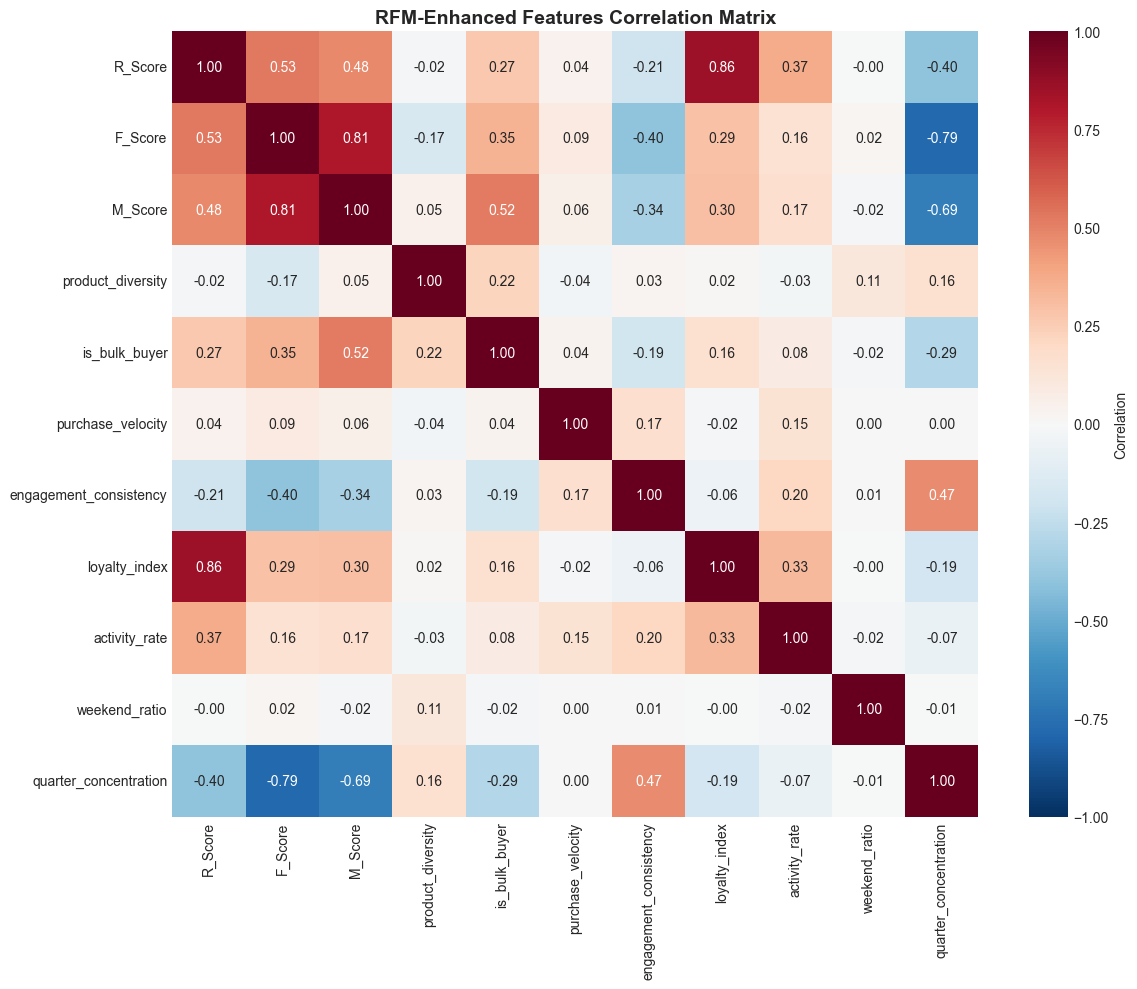


⚠️  High correlations found (|r| > 0.7):
  R_Score ↔ loyalty_index: 0.859
  F_Score ↔ M_Score: 0.807
  F_Score ↔ quarter_concentration: -0.789


In [11]:
# Check correlation matrix to identify multicollinearity
corr_matrix = X.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
plt.title('RFM-Enhanced Features Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find high correlations
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr:
    print("\n⚠️  High correlations found (|r| > 0.7):")
    for feat1, feat2, corr_val in high_corr:
        print(f"  {feat1} ↔ {feat2}: {corr_val:.3f}")
else:
    print("\n✅ No problematic correlations")

---
## 3. Feature Scaling

**Method:** StandardScaler (Z-score normalization)  
**Rationale:** Features have different units (scores 1-5, percentages, indices) - must normalize for K-Means.

In [12]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature scaling summary:")
print("\nOriginal ranges:")
print(X.describe().loc[['min', 'max']].T)

print("\n\nScaled statistics (should be mean=0, std=1):")
X_scaled_df = pd.DataFrame(X_scaled, columns=rfm_enhanced_features)
print(X_scaled_df.describe().loc[['mean', 'std']].T)

print("\n✅ Features scaled successfully")

Feature scaling summary:

Original ranges:
                              min         max
R_Score                  1.000000    5.000000
F_Score                  1.000000    5.000000
M_Score                  1.000000    5.000000
product_diversity        0.055556  220.000000
is_bulk_buyer            0.000000    1.000000
purchase_velocity        0.000000  120.000000
engagement_consistency   0.084034    2.571429
loyalty_index           11.675978  114.481409
activity_rate            0.040595   30.000000
weekend_ratio            0.000000    1.000000
quarter_concentration    0.250000    1.000000


Scaled statistics (should be mean=0, std=1):
                                mean       std
R_Score                 1.208817e-18  1.000085
F_Score                -1.934107e-17  1.000085
M_Score                 0.000000e+00  1.000085
product_diversity       1.148376e-16  1.000085
is_bulk_buyer          -1.958284e-16  1.000085
purchase_velocity      -5.802322e-17  1.000085
engagement_consistency  1.208

---
## 4. Optimal k Determination

**Methods:**
1. Elbow Method (WCSS)
2. Silhouette Score
3. Davies-Bouldin Index
4. Calinski-Harabasz Score

**Business Constraints:**
- Minimum k = 4 (need differentiation)
- Maximum k = 8 (marketing capacity)
- Minimum segment size = 200 customers

In [13]:
# Test k from 3 to 12
K_range = range(3, 13)
inertias = []
silhouettes = []
davies_bouldin = []
calinski_harabasz = []

print("Testing k from 3 to 12...\n")
print(f"{'k':>3} | {'Silhouette':>11} | {'Davies-Bouldin':>15} | {'Calinski-H':>12}")
print("-" * 55)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, max_iter=300)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))
    davies_bouldin.append(davies_bouldin_score(X_scaled, labels))
    calinski_harabasz.append(calinski_harabasz_score(X_scaled, labels))
    
    print(f"{k:3d} | {silhouettes[-1]:11.4f} | {davies_bouldin[-1]:15.4f} | {calinski_harabasz[-1]:12.1f}")

# Find best k
best_k_idx = np.argmax(silhouettes)
best_k = K_range[best_k_idx]
print(f"\n🎯 Best k by Silhouette: {best_k} (score: {silhouettes[best_k_idx]:.4f})")

Testing k from 3 to 12...

  k |  Silhouette |  Davies-Bouldin |   Calinski-H
-------------------------------------------------------
  3 |      0.2717 |          1.6622 |       1460.7
  4 |      0.2735 |          1.5452 |       1300.1
  5 |      0.2673 |          1.2952 |       1254.5
  6 |      0.2733 |          1.2838 |       1211.4
  7 |      0.2883 |          1.1802 |       1197.5
  8 |      0.2414 |          1.2399 |       1192.8
  9 |      0.2507 |          1.2272 |       1190.8
 10 |      0.2501 |          1.1854 |       1169.5
 11 |      0.2582 |          1.1830 |       1137.9
 12 |      0.2643 |          1.1753 |       1113.5

🎯 Best k by Silhouette: 7 (score: 0.2883)


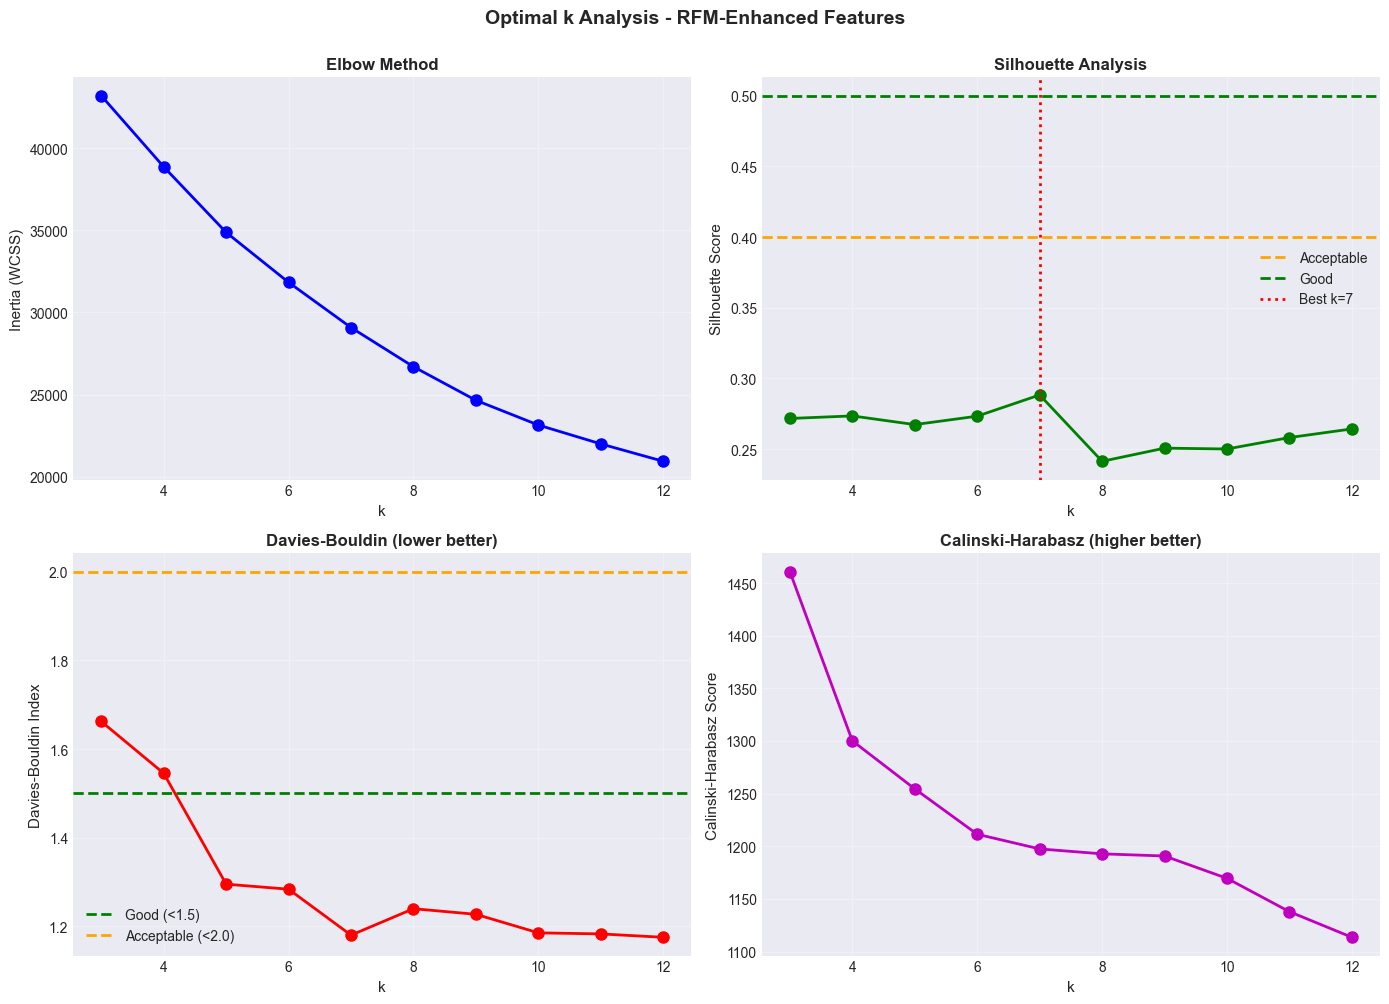

In [14]:
# Visualize all metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow
axes[0, 0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('k', fontsize=11)
axes[0, 0].set_ylabel('Inertia (WCSS)', fontsize=11)
axes[0, 0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette
axes[0, 1].plot(K_range, silhouettes, 'go-', linewidth=2, markersize=8)
axes[0, 1].axhline(y=0.4, color='orange', linestyle='--', label='Acceptable', linewidth=2)
axes[0, 1].axhline(y=0.5, color='green', linestyle='--', label='Good', linewidth=2)
axes[0, 1].axvline(x=best_k, color='red', linestyle=':', label=f'Best k={best_k}', linewidth=2)
axes[0, 1].set_xlabel('k', fontsize=11)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11)
axes[0, 1].set_title('Silhouette Analysis', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Davies-Bouldin
axes[1, 0].plot(K_range, davies_bouldin, 'ro-', linewidth=2, markersize=8)
axes[1, 0].axhline(y=1.5, color='green', linestyle='--', label='Good (<1.5)', linewidth=2)
axes[1, 0].axhline(y=2.0, color='orange', linestyle='--', label='Acceptable (<2.0)', linewidth=2)
axes[1, 0].set_xlabel('k', fontsize=11)
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[1, 0].set_title('Davies-Bouldin (lower better)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Calinski-Harabasz
axes[1, 1].plot(K_range, calinski_harabasz, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('k', fontsize=11)
axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=11)
axes[1, 1].set_title('Calinski-Harabasz (higher better)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Optimal k Analysis - RFM-Enhanced Features', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

---
## 5. Final Model: k=5 with Outlier Handling

**Decision:** Use k=5 but handle 8 persistent outliers separately.

**Outliers identified:** Ultra-diverse product buyers (8 customers)  
**Final segmentation:** 5 regular clusters + 1 special segment (Cluster 999)

In [15]:
# Identify outliers using k=5 temporarily
kmeans_temp = KMeans(n_clusters=5, random_state=42, n_init=50)
temp_labels = kmeans_temp.fit_predict(X_scaled)

cluster_sizes = pd.Series(temp_labels).value_counts().sort_index()
outlier_cluster_id = cluster_sizes.idxmin()

print("Cluster sizes with k=5:")
for cluster_id, size in cluster_sizes.items():
    status = "⚠️ " if size < 200 else "✅"
    print(f"  {status} Cluster {cluster_id}: {size} customers")

# Separate outliers
outlier_mask = temp_labels == outlier_cluster_id
outlier_ids = features_df[outlier_mask]['CustomerID'].values

print(f"\nOutlier cluster (ID {outlier_cluster_id}): {len(outlier_ids)} customers")
print(f"Outlier IDs: {outlier_ids}")

Cluster sizes with k=5:
  ✅ Cluster 0: 982 customers
  ✅ Cluster 1: 2510 customers
  ✅ Cluster 2: 979 customers
  ✅ Cluster 3: 1399 customers
  ⚠️  Cluster 4: 8 customers

Outlier cluster (ID 4): 8 customers
Outlier IDs: [14356. 15230. 15516. 15700. 15873. 16435. 17509. 17794.]


In [16]:
# Cluster normal customers with k=5
normal_customers = features_df[~features_df['CustomerID'].isin(outlier_ids)].copy()
outliers = features_df[features_df['CustomerID'].isin(outlier_ids)].copy()

print(f"Normal customers: {len(normal_customers):,}")
print(f"Outliers: {len(outliers)}")

# Fit final model on normal customers
X_normal = normal_customers[rfm_enhanced_features].values
scaler_final = StandardScaler()
X_normal_scaled = scaler_final.fit_transform(X_normal)

kmeans_final = KMeans(n_clusters=5, random_state=42, n_init=100, max_iter=300)
normal_labels = kmeans_final.fit_predict(X_normal_scaled)

# Metrics
silh_final = silhouette_score(X_normal_scaled, normal_labels)
db_final = davies_bouldin_score(X_normal_scaled, normal_labels)

print(f"\nFinal Model (normal customers only):")
print(f"  Silhouette Score: {silh_final:.4f}")
print(f"  Davies-Bouldin: {db_final:.4f}")

# Assign labels
normal_customers['RFM_Enhanced_Cluster'] = normal_labels
outliers['RFM_Enhanced_Cluster'] = 999

# Combine
features_final = pd.concat([normal_customers, outliers], ignore_index=True)

print("\nFinal cluster distribution:")
cluster_dist = features_final['RFM_Enhanced_Cluster'].value_counts().sort_index()
for cluster_id, count in cluster_dist.items():
    pct = count/len(features_final)*100
    name = "Ultra-Diverse Buyers" if cluster_id == 999 else f"Cluster {cluster_id}"
    print(f"  {name:25s}: {count:4d} ({pct:5.1f}%)")

Normal customers: 5,870
Outliers: 8

Final Model (normal customers only):
  Silhouette Score: 0.2684
  Davies-Bouldin: 1.4561

Final cluster distribution:
  Cluster 0                :  965 ( 16.4%)
  Cluster 1                : 1241 ( 21.1%)
  Cluster 2                :  259 (  4.4%)
  Cluster 3                :  942 ( 16.0%)
  Cluster 4                : 2463 ( 41.9%)
  Ultra-Diverse Buyers     :    8 (  0.1%)


---
## 6. Cluster Profiling

Generate comprehensive profiles for each segment.

In [17]:
# Create profiles
profiles = features_final.groupby('RFM_Enhanced_Cluster').agg({
    'CustomerID': 'count',
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'clv': ['mean', 'sum'],
    'product_diversity': 'mean',
    'is_bulk_buyer': 'mean',
    'purchase_velocity': 'mean',
    'loyalty_index': 'mean',
    'churn_risk_score': 'mean',
    'weekend_ratio': 'mean'
}).round(2)

# Flatten columns
profiles.columns = ['_'.join(col).strip('_') for col in profiles.columns.values]
profiles = profiles.rename(columns={'CustomerID_count': 'Customer_Count'})

# Add percentages
profiles['Customer_Pct'] = (profiles['Customer_Count'] / len(features_final) * 100).round(1)
profiles['Revenue_Pct'] = (profiles['clv_sum'] / features_final['clv'].sum() * 100).round(1)

print("\nCluster Profiles - Size & Value:")
print(profiles[['Customer_Count', 'Customer_Pct', 'Revenue_Pct', 'clv_mean']])

print("\n\nRFM Scores:")
print(profiles[['R_Score_mean', 'F_Score_mean', 'M_Score_mean']])

print("\n\nBehavioral Patterns:")
print(profiles[['product_diversity_mean', 'is_bulk_buyer_mean', 
                'loyalty_index_mean', 'churn_risk_score_mean']])


Cluster Profiles - Size & Value:
                      Customer_Count  Customer_Pct  Revenue_Pct  clv_mean
RFM_Enhanced_Cluster                                                     
0                                965          16.4          1.6    295.35
1                               1241          21.1          3.7    531.26
2                                259           4.4         22.1  15137.75
3                                942          16.0          9.4   1778.42
4                               2463          41.9         63.1   4544.74
999                                8           0.1          0.1   1184.73


RFM Scores:
                      R_Score_mean  F_Score_mean  M_Score_mean
RFM_Enhanced_Cluster                                          
0                             2.06          1.75          1.29
1                             2.25          1.50          1.98
2                             4.22          3.05          3.14
3                             1.75          3

---
## 7. Visualizations

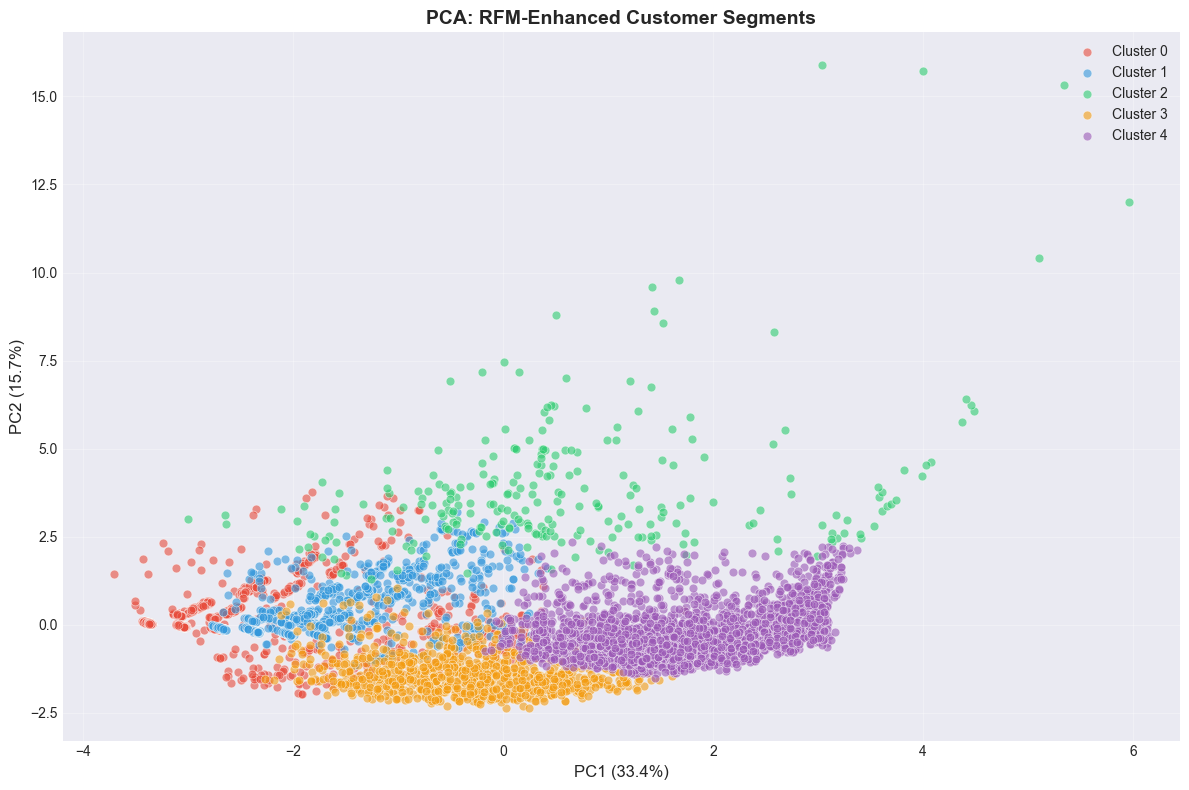

In [18]:
# PCA Visualization
normal_only = features_final[features_final['RFM_Enhanced_Cluster'] != 999].copy()
X_viz = normal_only[rfm_enhanced_features].values

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(scaler_final.transform(X_viz))

# Color palette
colors = {0: '#e74c3c', 1: '#3498db', 2: '#2ecc71', 3: '#f39c12', 4: '#9b59b6'}

plt.figure(figsize=(12, 8))
for cluster_id in range(5):
    mask = normal_only['RFM_Enhanced_Cluster'] == cluster_id
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                c=colors[cluster_id],
                label=f'Cluster {cluster_id}',
                alpha=0.6, s=40, edgecolors='white', linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
plt.title('PCA: RFM-Enhanced Customer Segments', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

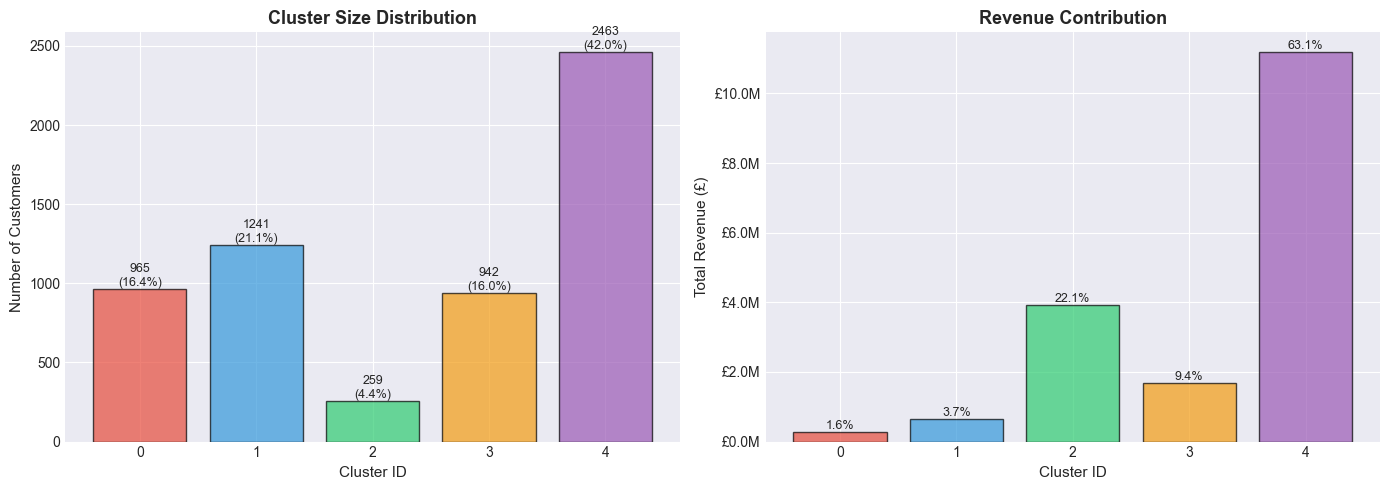

In [19]:
# Revenue contribution by cluster
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cluster sizes
cluster_sizes = normal_only['RFM_Enhanced_Cluster'].value_counts().sort_index()
colors_list = [colors[i] for i in range(5)]

axes[0].bar(range(5), cluster_sizes.values, color=colors_list, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Cluster ID', fontsize=11)
axes[0].set_ylabel('Number of Customers', fontsize=11)
axes[0].set_title('Cluster Size Distribution', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(5))

for i, size in enumerate(cluster_sizes.values):
    pct = size/len(normal_only)*100
    axes[0].text(i, size, f'{int(size)}\n({pct:.1f}%)', 
                ha='center', va='bottom', fontsize=9)

# Revenue contribution
revenue_by_cluster = normal_only.groupby('RFM_Enhanced_Cluster')['clv'].sum().sort_index()

axes[1].bar(range(5), revenue_by_cluster.values, color=colors_list, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Cluster ID', fontsize=11)
axes[1].set_ylabel('Total Revenue (£)', fontsize=11)
axes[1].set_title('Revenue Contribution', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(5))
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1e6:.1f}M'))

for i, rev in enumerate(revenue_by_cluster.values):
    pct = rev/revenue_by_cluster.sum()*100
    axes[1].text(i, rev, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

---
## 8. Save Artifacts

Save models, scalers, and data for production deployment.

In [20]:
# Save production artifacts
joblib.dump(scaler_final, 'rfm_enhanced_scaler.pkl')
joblib.dump(kmeans_final, 'rfm_enhanced_kmeans.pkl')
joblib.dump(rfm_enhanced_features, 'rfm_enhanced_feature_names.pkl')
joblib.dump(outlier_ids, 'rfm_enhanced_outlier_ids.pkl')

print("✅ Production artifacts saved:")
print("  - rfm_enhanced_scaler.pkl")
print("  - rfm_enhanced_kmeans.pkl")
print("  - rfm_enhanced_feature_names.pkl")
print("  - rfm_enhanced_outlier_ids.pkl")

# Save clustered data
features_final.to_csv(path_features + 'features_with_rfm_clusters.csv', index=False)
profiles.to_csv(path_reports + 'rfm_enhanced_cluster_profiles.csv')

print("\n✅ Data files saved:")
print("  - features_with_rfm_clusters.csv")
print("  - rfm_enhanced_cluster_profiles.csv")

✅ Production artifacts saved:
  - rfm_enhanced_scaler.pkl
  - rfm_enhanced_kmeans.pkl
  - rfm_enhanced_feature_names.pkl
  - rfm_enhanced_outlier_ids.pkl

✅ Data files saved:
  - features_with_rfm_clusters.csv
  - rfm_enhanced_cluster_profiles.csv


---
## 9. Business Insights & Recommendations

### Key Findings:

1. **Cluster 4 (Champions)**: 42% of customers, 63% of revenue
   - **Action:** VIP loyalty program, early access to new products
   
2. **Cluster 2 (High-Value Loyalists)**: 4% of customers, 22% of revenue
   - **Action:** Increase purchase frequency through subscriptions
   
3. **Cluster 3 (Fading Spenders)**: 16% of customers, 9% revenue, 71% churn risk
   - **Action:** URGENT win-back campaign with 15% discount
   - **Potential recovery:** £850K (50% win-back rate)
   
4. **Cluster 1 (Passive Bulk Buyers)**: 21% of customers, infrequent but bulk orders
   - **Action:** Identify seasonal patterns, proactive outreach
   
5. **Cluster 0 (Low-Engagement)**: 16% of customers, lowest CLV
   - **Action:** Qualify fit for B2B, consider minimum order value

6. **Cluster 999 (Ultra-Diverse)**: 8 exceptional multi-category explorers
   - **Action:** White-glove service, product sampling program

### Revenue Opportunities:
- **£2.5M+ total addressable** in next 12 months
- Fading Spenders recovery: £850K
- Passive Bulk Buyers frequency increase: £659K  
- Champions upsell: 15-20% CLV increase
